In [29]:
import pandas as pd
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 
from collections import Counter
import seaborn as sns
import numpy as np
import re

from datasets import list_datasets, load_dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martinthoma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martinthoma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:

books_data_shuffled = books_data_raw.shuffle()
news_data_shuffled = news_data_raw.shuffle()


Reusing dataset bookcorpus (C:\Users\math.digi\.cache\huggingface\datasets\bookcorpus\plain_text\1.0.0\af844be26c089fb64810e9f2cd841954fd8bd596d6ddd26326e4c70e2b8c96fc)
Using custom data configuration default
Reusing dataset ag_news (C:\Users\math.digi\.cache\huggingface\datasets\ag_news\default\0.0.0\fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a)
Loading cached shuffled indices for dataset at C:\Users\math.digi\.cache\huggingface\datasets\bookcorpus\plain_text\1.0.0\af844be26c089fb64810e9f2cd841954fd8bd596d6ddd26326e4c70e2b8c96fc\cache-a676355080ae5835.arrow


In [17]:
# load different corpora in dataframes
df_train = pd.read_csv('./datasets/training_set', delimiter=',')
df_sdg = df_train[df_train.loc[:, 'labels'] != 0]
df_monster = pd.read_csv('./datasets/monster_com-job_sample.csv')
df_indeed = pd.read_csv('./datasets/indeed_job_data_raw.csv')
df_wiki = pd.read_csv('./datasets/wikisent2.txt',delimiter='\t')
books_data_raw = load_dataset('bookcorpus')
news_data_raw = load_dataset('ag_news')
# can not use open web data because it does not fit on disk
#open_data = load_dataset(path='openwebtext', split='train[:1%]')

In [44]:
# curate approx of Roberta pretraining corpus

# shuffle data
books_data_shuffled = books_data_raw.shuffle()
news_data_shuffled = news_data_raw.shuffle()
df_wiki_shuffled = df_wiki.sample(frac=1).reset_index(drop=True)

# draw 150K samples per corpus 
books_sample = books_data_shuffled['train'][:150000]['text']
news_sample = news_data_shuffled['train'][:150000]['text']
wiki_sample = list(df_wiki_shuffled.iloc[:150000, 0].values)

# concat subcorpora 
roberta_pretrain = books_sample + news_sample + wiki_sample

In [50]:
def get_words(sentences):
    """
    Concatenate sentences made out of word tokens.
    return single list of words
    """
    words = []
    for sentence in sentences:
        words += sentence
    return words

In [53]:
# create word lists from datasets
roberta_words = get_words([word_tokenize(sentence) for sentence in roberta_pretrain])
sdg_words = get_words([word_tokenize(sentence) for sentence in list(df_sdg['sentence'].values)])
indeed_words = get_words([word_tokenize(sentence) for sentence in list(df_indeed['text_en'].values)])
monster_words = get_words([word_tokenize(sentence) for sentence in list(df_monster['job_description'].values)])

In [55]:
# clean word lists from stopwords
roberta_filtered = [w for w in roberta_words if not w in stop_words] 
sdg_filtered = [w for w in sdg_words if not w in stop_words] 
indeed_filtered = [w for w in indeed_words if not w in stop_words] 
monster_filtered = [w for w in monster_words if not w in stop_words] 

In [56]:
# init counter object with word list
RobertaCounter = Counter(roberta_filtered)
SDGCounter = Counter(sdg_filtered)
IndeedCounter = Counter(indeed_filtered)
MonsterCounter = Counter(monster_filtered)

In [57]:
# draw the 10,000 most common words for each corpus
nb_most = 10000
roberta_most_nb = RobertaCounter.most_common(nb_most)
sdg_most_nb = SDGCounter.most_common(nb_most)
indeed_most_nb = IndeedCounter.most_common(nb_most)
monster_most_nb = MonsterCounter.most_common(nb_most)

In [58]:
# remove counts ang get list of most frequent words only
roberta_most = [w[0] for w in roberta_most_nb]
sdg_most = [w[0] for w in sdg_most_nb]
indeed_most = [w[0] for w in indeed_most_nb]
monster_most = [w[0] for w in monster_most_nb]

In [59]:
# calculate percentage intersections between corpora
roberta_sdg = len(list(set(roberta_most) & set(sdg_most))) / nb_most
roberta_monster = len(list(set(roberta_most) & set(monster_most))) / nb_most
roberta_indeed = len(list(set(roberta_most) & set(indeed_most))) / nb_most
sdg_monster = len(list(set(sdg_most) & set(monster_most))) / nb_most
sdg_indeed = len(list(set(sdg_most) & set(indeed_most))) / nb_most
monster_indeed = len(list(set(monster_most) & set(indeed_most))) / nb_most

In [60]:
# manually curate overlap matrix and annotation for corpora similarity
cm = np.array([[1, roberta_sdg, roberta_monster, roberta_indeed],
               [roberta_sdg, 1, sdg_monster, sdg_indeed],
               [roberta_indeed, sdg_indeed, 1, monster_indeed],
               [roberta_monster, sdg_monster, monster_indeed, 1]])

annot = ['{0:.2f}%'.format(float(a)*100) for a in np.array(cm).flatten()]
annot = np.asarray(annot).reshape(cm.shape[0],cm.shape[1])

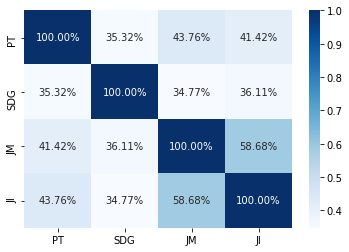

In [72]:
# print corpora similarity matrix
sns_plot = sns.heatmap(data=cm, 
                       cmap='Blues', 
                       fmt='4', 
                       xticklabels=['PT', 'SDG', 'JM', 'JI'], 
                       yticklabels=['PT', 'SDG', 'JM', 'JI'], 
                       annot=annot)
fig = sns_plot.get_figure()
fig.savefig("./plots/corpora_similarity_matrix.png")

### Simple training data statistics

In [47]:
target_file_path = './datasets/dev_test_set_u_prelabelled_labelled.xls'
target_col = 'human_label'

In [23]:
df = pd.read_excel(target_file_path)

In [49]:
df = df.loc[~df[target_col].isnull(), : ]

In [50]:
df.head()

,id,comp_name,sentence,model_most_likely,human_label
0,07e45bf1b3a39e5d,engie,ENGIE are recruiting for a Mobile Contract Sup...,0.0,0
1,07e45bf1b3a39e5d,engie,"This is a permanent, full time role working 40...",0.0,0
2,07e45bf1b3a39e5d,engie,"On offer is a salary of ¬£35,000 - ¬£37,500 de...",0.0,1
3,07e45bf1b3a39e5d,engie,Provide Technical Assistance to other Engineer...,0.0,0
4,07e45bf1b3a39e5d,engie,Maintain all PPM and Reactive Repairs Records ...,0.0,0


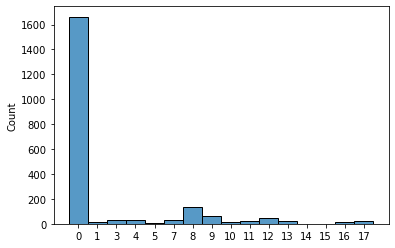

In [61]:

sns_histplot = sns.histplot(sorted([label for int_label in df[target_col] for label in re.findall(r"[\w']+", str(int_label))], key=int))
#sns_histplot = sns.histplot(sorted([label for int_label in df['human_label'] for label in str(int_label).split()], key=int))
fig = sns_histplot.get_figure()
fig.savefig("./plots/histogram_prelabelled_labelled_SDG_wiki.png")